In [1]:
from pathlib import Path


result_folder = Path(
    "/vol/bitbucket/ad6013/Research/CausalStructureNeuralProcess/ml2_meta_causal_discovery/experiments/causal_classification/linear_gaussian"
)
result_file = result_folder / "results_2var_withqlbefore.json"


In [2]:
import json


with open(result_file, "r") as f:
    results = json.load(f)

In [3]:
for model, scores in results.items():
    print(f"Model: {model}")
    for score, value in scores.items():
        print(f"  {score}: {value}")
    print()

Model: avici
  e_shd: [0.8360000252723694, 0.8519999980926514, 1.0440000295639038, 0.828000009059906, 1.2699999809265137, 1.0140000581741333, 0.8960000276565552, 0.8560000061988831, 0.828000009059906, 1.2419999837875366, 1.281999945640564, 0.9520000219345093, 1.2239999771118164, 1.1820000410079956, 1.187999963760376, 1.062000036239624, 1.1360000371932983, 1.2799999713897705, 0.7799999713897705, 0.8180000185966492, 1.2920000553131104, 0.8240000009536743, 0.7860000133514404, 1.2519999742507935, 0.9480000138282776, 0.6940000057220459, 0.9480000138282776, 1.027999997138977, 1.184000015258789, 1.0759999752044678, 0.9800000190734863, 0.8240000009536743, 1.1100000143051147, 0.972000002861023, 0.7720000147819519, 1.0160000324249268, 0.7059999704360962, 0.9959999918937683, 0.9620000123977661, 0.9959999918937683, 0.8199999928474426, 1.0720000267028809, 0.6679999828338623, 1.0800000429153442, 0.8700000047683716, 1.159999966621399, 1.184000015258789, 0.9919999837875366, 1.1180000305175781, 1.21399

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def create_plots(data):
    # Convert the nested dictionary to a pandas DataFrame
    df = pd.DataFrame([
        (model, 'e_shd', value)
        for model, scores in data.items()
        for value in scores['e_shd']
    ] + [
        (model, 'auc', value)
        for model, scores in data.items()
        for value in scores['auc']
    ] + [
        (model, 'log_prob', value)
        for model, scores in data.items()
        for value in scores['log_prob']
    ] + [
        (model, 'e_f1', value)
        for model, scores in data.items()
        for value in scores['e_f1'] if value != 0
    ], columns=['Model', 'Metric', 'Score'])

    # Create a separate DataFrame for test loss
    df_test_loss = pd.DataFrame([
        (model, scores['test_loss'])
        for model, scores in data.items()
    ], columns=['Model', 'Test Loss'])

    # Set up the matplotlib figure
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 24))
    fig.suptitle('Model Performance Metrics', fontsize=16)

    medianprops = dict(color="red", linewidth=2)

    # Create box plot for e_shd
    sns.boxplot(x='Model', y='Score', data=df[df['Metric'] == 'e_shd'], ax=ax1, medianprops=medianprops)
    ax1.set_title('E_SHD Scores')
    ax1.set_xlabel('Model')
    ax1.set_ylabel('E_SHD Score')

    # Create box plot for e_f1
    sns.boxplot(x='Model', y='Score', data=df[df['Metric'] == 'e_f1'], ax=ax2, medianprops=medianprops)
    ax2.set_title('E_F1 Scores')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('E_F1 Score')

    sns.boxplot(x='Model', y='Score', data=df[df['Metric'] == 'auc'], ax=ax3, medianprops=medianprops)
    ax3.set_title('AUC Scores')
    ax3.set_xlabel('Model')
    ax3.set_ylabel('AUC Score')

    # Create box plot for e_f1
    sns.boxplot(x='Model', y='Score', data=df[df['Metric'] == 'log_prob'], ax=ax4, medianprops=medianprops)
    ax4.set_title('Log Prob Scores')
    ax4.set_xlabel('Model')
    ax4.set_ylabel('Log Prob Score')

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()


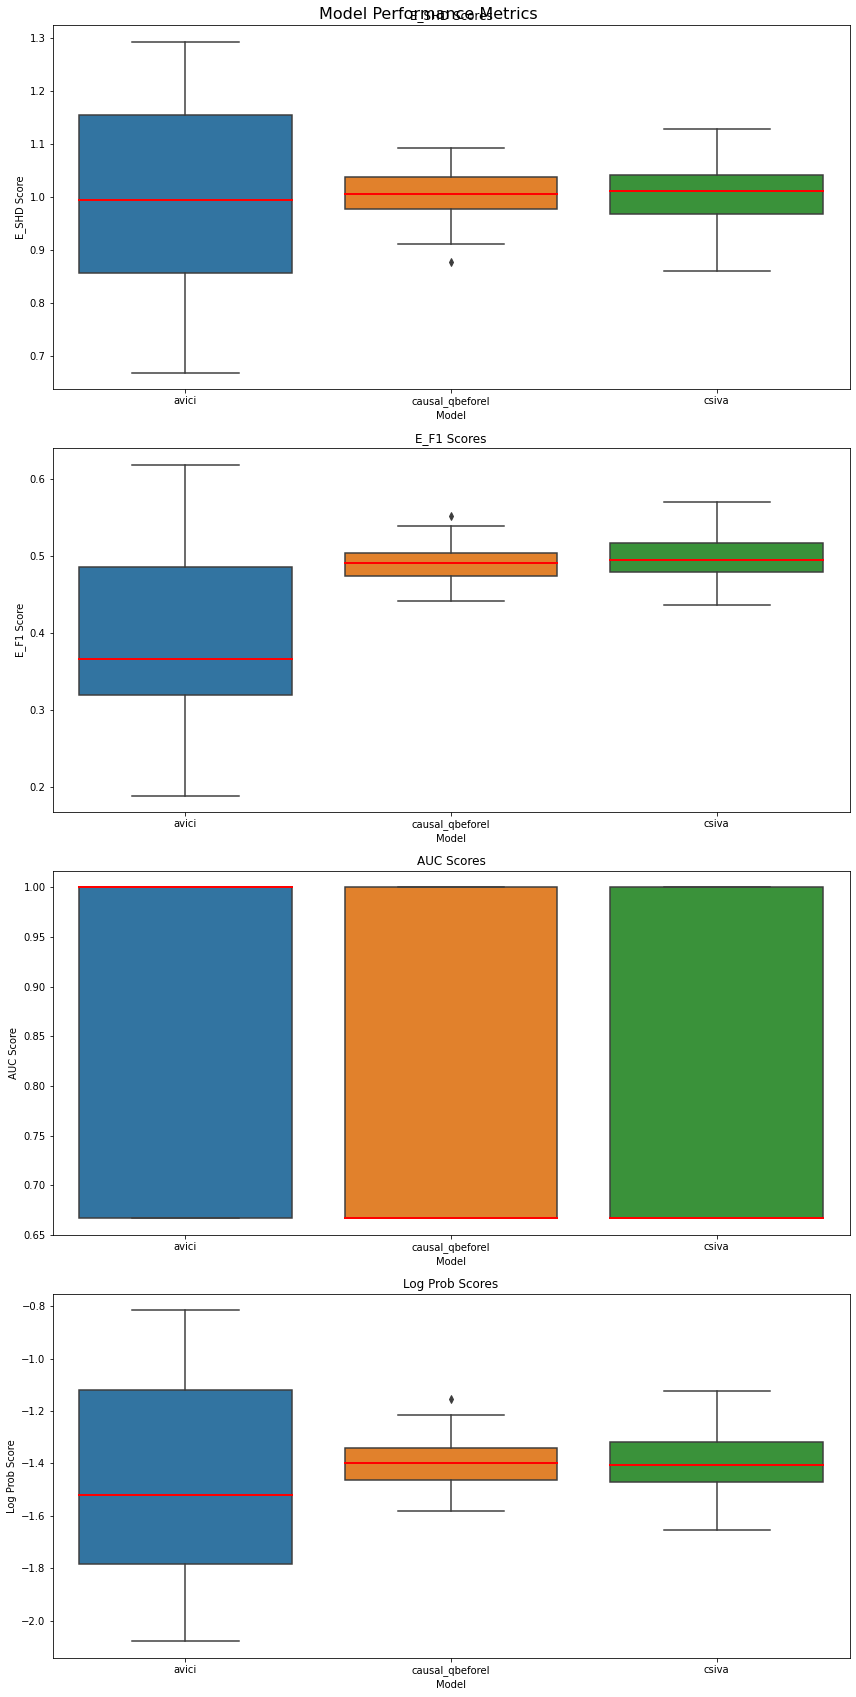

In [5]:
create_plots(
    results
)

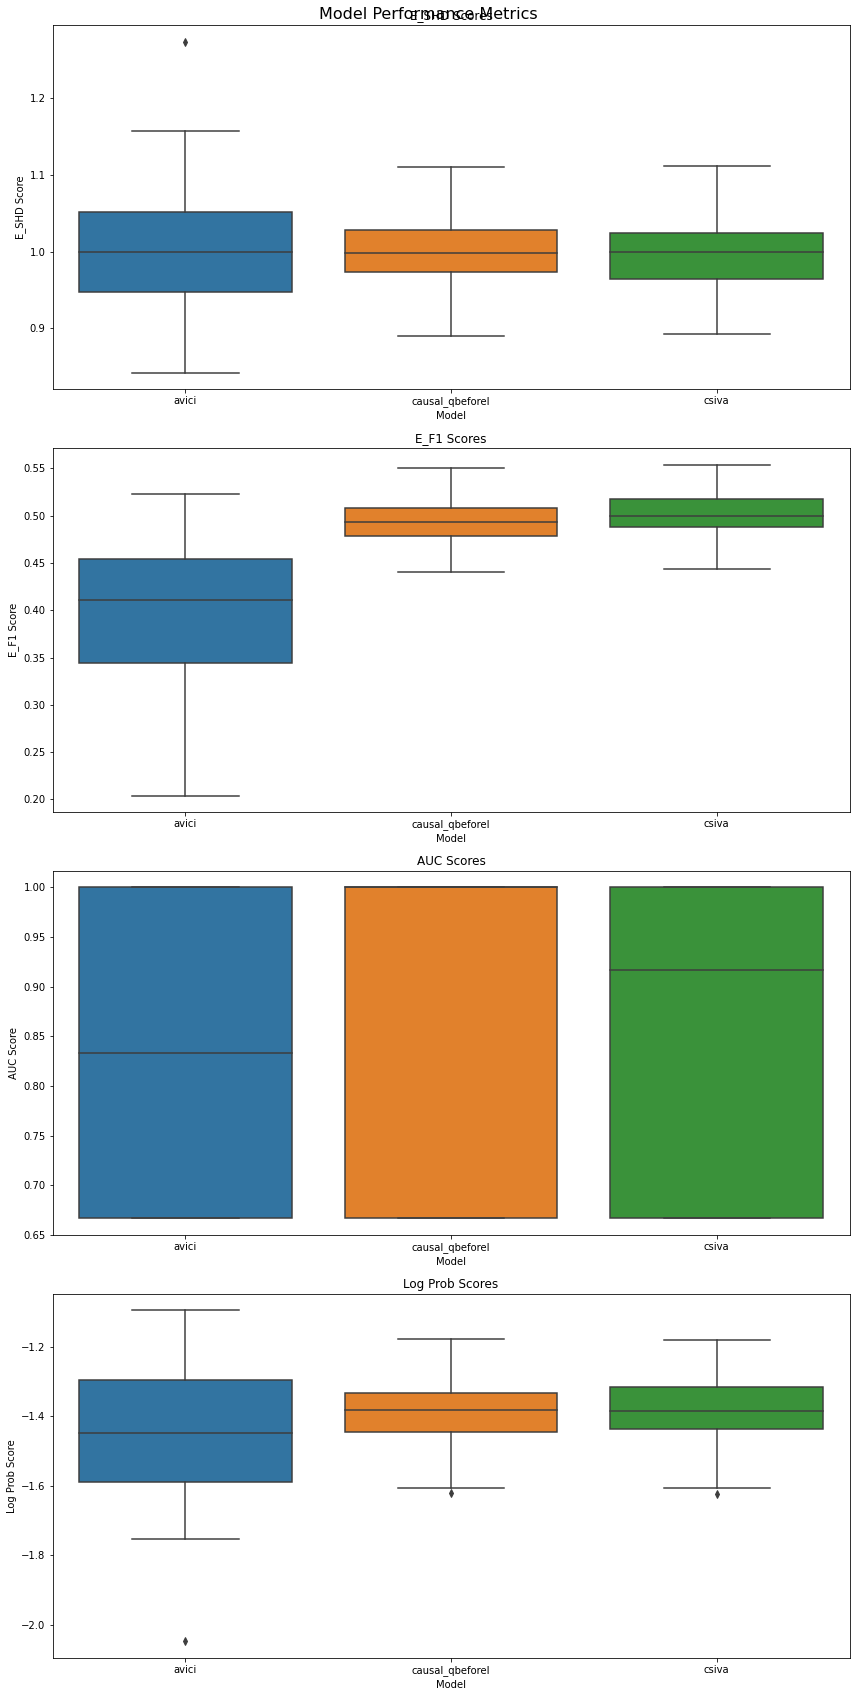

In [38]:
create_plots(
    results
)

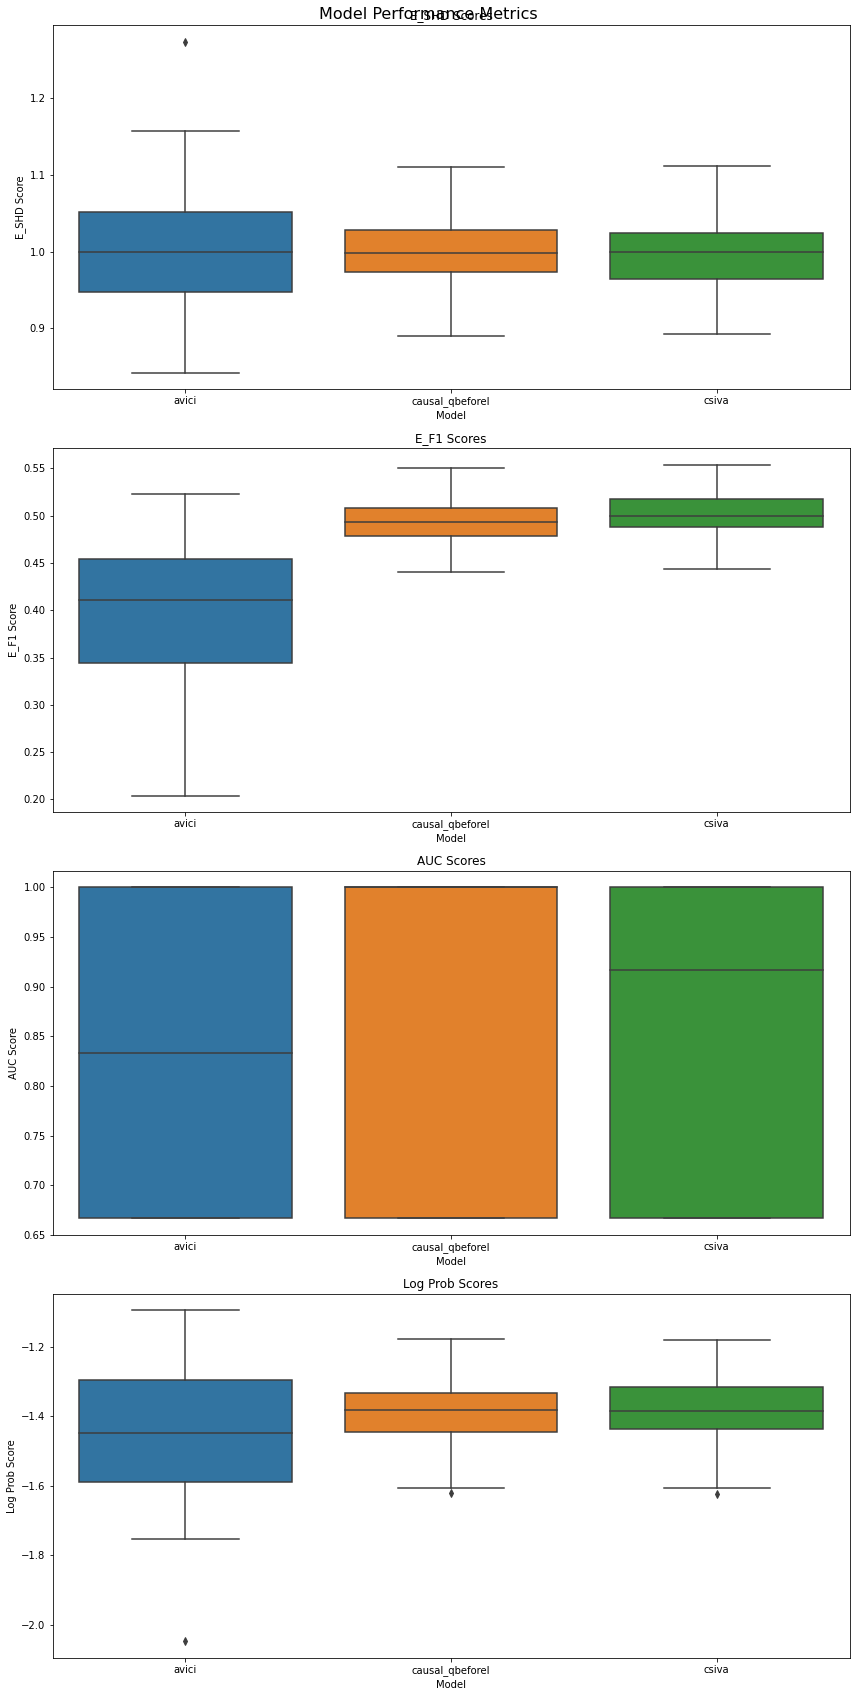

In [39]:
create_plots(
    results
)

In [1]:
import torch as th
from ml2_meta_causal_discovery.utils.datautils import MultipleFileDatasetWithPadding
from pathlib import Path
from ml2_meta_causal_discovery.models.causaltransformernp import (
    AviciDecoder,
    CsivaDecoder,
    CausalProbabilisticDecoder,
)
from ml2_meta_causal_discovery.utils.metrics import (
    expected_shd,
    expected_f1_score,
    auc_graph_scores,
    log_prob_graph_scores
)
import numpy as np
from collections import Counter
from tqdm import trange
from ml2_meta_causal_discovery.datasets.dataset_generators import \
    ClassifyDatasetGenerator
import h5py


model_folder = Path(
    "/vol/bitbucket/ad6013/Research/CausalStructureNeuralProcess/ml2_meta_causal_discovery/experiments/causal_classification/models"
)
MODELS = {
    "causal_qbeforel": CausalProbabilisticDecoder,
    # "avici": AviciDecoder,
    # "csiva": CsivaDecoder,

}
# Define the path to the test file
test_file = Path(
    "/vol/bitbucket/ad6013/Research/CausalStructureNeuralProcess/ml2_meta_causal_discovery/datasets/data/synth_training_data/linear_gaussian/test_data.hdf5"
)
num_nodes = 3
datagenerator = ClassifyDatasetGenerator(
    num_variables=2,
    function_generator="linear",
    batch_size=200,
    num_samples=1000,
    graph_type=["ER"],
    graph_degrees=[1]
)
data, causal_graphs = next(datagenerator.generate_next_dataset())[:]
# Normalise the data along the 1st axis
data = (data - data.mean(axis=1, keepdims=True)) / data.std(axis=1, keepdims=True)
with h5py.File(test_file, "w") as f:
    f.create_dataset("data", data=data)
    f.create_dataset("label", data=causal_graphs)
# Load the models
test_dataset = MultipleFileDatasetWithPadding(
        [test_file], max_node_num=num_nodes
    )
test_loader = th.utils.data.DataLoader(
    test_dataset,
    batch_size=50,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
)

# Train all the models
TNPD_KWARGS = dict(
    d_model=256,
    emb_depth=1,
    dim_feedforward=512,
    nhead=8,
    dropout=0.0,
    num_layers_encoder=4,
    num_layers_decoder=4,
    device="cuda" if th.cuda.is_available() else "cpu",
    dtype=th.float32,
    num_nodes=num_nodes,
    n_perm_samples=25,
    sinkhorn_iter=1000,
    use_positional_encoding=False,
)

def count_graphs(x):
    # Convert each adjacency matrix to a tuple of its flattened elements
    adj_tuples = [tuple(matrix.flatten()) for matrix in x]
    # Use Counter to count the occurrences of each unique adjacency matrix
    counts = Counter(adj_tuples)
    return counts


all_shd_dict = {}
all_f1_dict = {}
all_auc_dict = {}
all_log_prob_dict = {}
all_graph_counts = {}
total_acyclic = {model:0 for model in MODELS.keys()}
for model_name, model_class in MODELS.items():
    model = model_class(**TNPD_KWARGS)
    model.load_state_dict(th.load(model_folder / f"linear_gaussian_{model_name}" / "model_0.pt"))
    model.eval()
    model.to(TNPD_KWARGS['device'])
    graph_counter = None
    with th.no_grad():
        all_f1_scores = []
        all_shd_scores = []
        all_auc_scores = []
        all_log_prob_scores = []
        for data in test_loader:
            # Create normalised 2var data
            # x = th.randn(1, 1000, 1)
            # y = x @ th.randn(1, 1) + th.randn(1, 1000, 1) * 0.1
            # z = th.randn(1, 1000, 1)
            # full_data = th.cat([x, y, z], dim=-1)
            # norm_full_data = (full_data - full_data.mean(dim=1, keepdim=True)) / full_data.std(dim=1, keepdim=True)
            # label = th.tensor([[0, 1, 0], [0, 0, 0], [0, 0, 0]]).to(th.float32)[None]
            # x = norm_full_data.to(TNPD_KWARGS['device'], th.float32)
            # label = label.to(th.float32)
            assert (data[1].sum(dim=-1).sum(-1) == 1).all()
            # data = test_dataset[i]
            x, label, mask = data[0].to(TNPD_KWARGS['device']), data[1], data[2].to(TNPD_KWARGS['device'], dtype=th.float32)
            x = x.to(th.float32)
            label = label.to(th.float32)
            # x = x[None]
            # label = label[None]
            pred, mask = model.sample(x, num_samples=500, mask=mask)
            # Calculate log prob
            log_prob = log_prob_graph_scores(label, pred.detach().cpu())
            all_log_prob_scores.append(log_prob)
            pred_analyse = pred.detach().cpu().numpy()

            # Flattern the first two axes
            # pred_analyse = pred_analyse.reshape(-1, 2, 2)

            if graph_counter is None:
                graph_counter = count_graphs(pred_analyse.reshape(-1, num_nodes, num_nodes))
            else:
                graph_counter += count_graphs(pred_analyse.reshape(-1, num_nodes, num_nodes))

            # Count unmber of acyclic graphs
            # num_acyclic = sum([cyclicity(sample[0]) > 0 for sample in pred_analyse.detach().cpu()])
            # total_acyclic[model_name] += num_acyclic
            # Calculate SHD
            shd = expected_shd(label.numpy(), pred_analyse)
            all_shd_scores.append(shd)
            # Calculate F1
            f1_score = expected_f1_score(label, pred_analyse)
            all_f1_scores.append(f1_score)
            # Calculate AUC
            auc = auc_graph_scores(label, pred_analyse)
            all_auc_scores.append(auc)

        all_shd_dict[model_name] = all_shd_scores
        all_f1_dict[model_name] = all_f1_scores
        all_auc_dict[model_name] = all_auc_scores
        all_log_prob_dict[model_name] = all_log_prob_scores
        all_graph_counts[model_name] = graph_counter

2024-10-23 10:55:23.755847: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-10-23 10:55:23.755860: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
100%|██████████| 200/200 [00:00<00:00, 3903.08it/s]


Using 2 decoder layers.


/tmp/ipykernel_3418562/3792394782.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(th.load(model_folder / f"linear_gaussian_{model_name}" / "model_

In [ ]:
pred

tensor([[[[0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 0., 0.],
          [1., 0., 0.],
          [0., 0., 0.]],

         [[0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         ...,

         [[0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],

         [[0., 1., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]],


        [[[0., 0., 0.],
          [1., 0., 0.],
          [0., 0., 0.]],

    

In [8]:
np.mean(all_auc_dict['causal_qbeforel'])

0.8308333333333333

In [9]:
np.mean(all_auc_dict['avici'])

0.8313333333333333

In [10]:
np.mean(all_auc_dict['csiva'])

0.8319999999999999

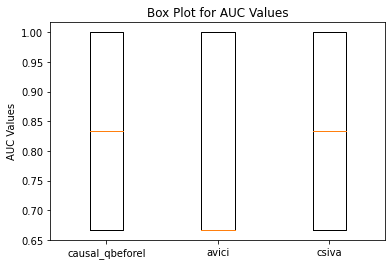

In [15]:
def plot_auc_boxplot(data_dict):
    """
    Creates a box plot for the AUC values in a dictionary where the values are lists of arrays.

    :param data_dict: Dictionary where values are lists of arrays
    """
    # Convert dictionary values (arrays) to a list of numeric values for each key
    data_values = {key: [item for sublist in values for item in sublist] for key, values in data_dict.items()}

    # Create boxplot
    plt.boxplot(data_values.values())

    # Set x-ticks to the dictionary keys
    plt.xticks(range(1, len(data_dict.keys()) + 1), data_dict.keys())

    # Add titles and labels
    plt.title('Box Plot for AUC Values')
    plt.ylabel('AUC Values')

    # Show plot
    plt.show()

plot_auc_boxplot(all_auc_dict)

In [12]:
np.mean(all_log_prob_dict['causal_qbeforel'])

-1.3884645295143128

In [13]:
np.mean(all_log_prob_dict['avici'])

-1.454101701796055

In [14]:
np.mean(all_log_prob_dict['csiva'])

-1.3867279814481734

In [3]:
all_graph_counts

{'causal_qbeforel': Counter({(0.0,
           0.0,
           0.0,
           1.0,
           0.0,
           0.0,
           0.0,
           0.0,
           0.0): 49540,
          (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): 49115,
          (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): 1345})}

In [7]:
648 / 10000

0.0648

In [24]:
all_f1_dict = {model: [score for score in scores if score != 0] for model, scores in all_f1_dict.items()}

In [7]:
def plot_boxplot(data_dict):
    """
    Creates a box plot for the values in a dictionary where the values are arrays.

    :param data_dict: Dictionary where values are arrays or lists of arrays
    """
    # Convert dictionary values (arrays) to a list of numeric values for each key
    data_values = {key: [item[0] if isinstance(item, np.ndarray) else item for item in values] for key, values in data_dict.items()}

    # Create boxplot
    plt.boxplot(data_values.values())

    # Set x-ticks to the dictionary keys
    plt.xticks(range(1, len(data_dict.keys()) + 1), data_dict.keys())

    # Add titles and labels
    plt.title('Box Plot for Dictionary Data')
    plt.ylabel('Values')

    # Show plot
    plt.show()




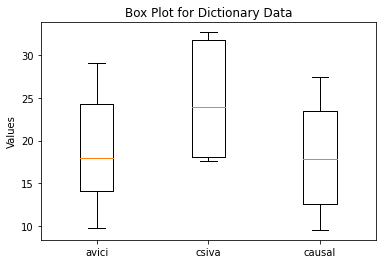

In [8]:
plot_boxplot(all_shd_dict)

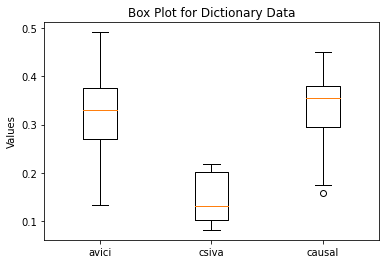

In [9]:
plot_boxplot(all_f1_dict)

In [12]:
label.shape

torch.Size([1, 3, 3])

In [13]:
all_f1_dict

{'csiva': 0.29607000000000006,
 'causal': 0.23076666666666665,
 'avici': 0.150195}

In [2]:
all_f1_dict

{'csiva': 0.8187866666666668,
 'causal': 0.7690533333333335,
 'avici': 0.7694223809523809}

In [2]:
all_f1_dict

{'csiva': 0.29141999999999996,
 'causal': 0.7429300000000001,
 'avici': 0.7513157142857143}

In [15]:
# Count number of acyclic samples
for model_name, samples in all_samples.items():
    print(f"Model: {model_name}")
    num_selfloop = 0
    num_cyclic = 0
    num_indep = 0
    for sample in samples:
        sample = sample.squeeze(0)
        if sample[0, 0] == 1 or sample[1, 1] == 1 or sample[2, 2] == 1:
            num_selfloop += 1
        elif sample[0, 1] == 1 and sample[1, 0] == 1:
            num_cyclic += 1
        elif sample[0, 1] == 0 and sample[1, 0] == 0:
            num_indep += 1

    print(f"  Self-loop: {num_selfloop}")
    print(f"  Cyclic: {num_cyclic}")
    print(f"  Independent: {num_indep}")

Model: csiva
  Self-loop: 28
  Cyclic: 0
  Independent: 0
Model: causal
  Self-loop: 0
  Cyclic: 0
  Independent: 0
Model: avici
  Self-loop: 58
  Cyclic: 0
  Independent: 24


In [15]:
from ml2_meta_causal_discovery.datasets.causal_graph_generator import (
    generate_synthetic_dag,
)

import numpy as np

dag = generate_synthetic_dag(3, np.random.randint(0, 4), "ER")

In [10]:
samples

array([[[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 1.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
         [1., 0., 0.]]],


       [[[0., 0., 0.],
         [1., 0., 1.],
     

In [95]:
import numpy as np

np.random.randint(0, 4)

2

In [24]:
import h5py

data_file = Path(
    "/vol/bitbucket/ad6013/Research/CausalStructureNeuralProcess/ml2_meta_causal_discovery/datasets/data/synth_training_data/linear_gaussian/train_data.hdf5"
)

with h5py.File(data_file, "r") as f:
    data = f["data"][:]
    labels = f["label"][:]

In [28]:
# Get bin count of the number of edges
bin_counts = {}
for graph in labels:
    num_edges = np.sum(graph)
    if num_edges not in bin_counts:
        bin_counts[num_edges] = 0
    bin_counts[num_edges] += 1

In [29]:
bin_counts

{1.0: 33593, 3.0: 33312, 2.0: 33095}

In [34]:
labels[3]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 0.]])

In [6]:
from collections import Counter

count = Counter([])

In [9]:
import numpy as np

x = np.array([
    [
        [0, 1],
        [0, 0],
    ],
    [
        [0, 0],
        [1, 0],
    ],
    [
        [0, 1],
        [0, 0],
    ]
])

In [17]:
x.shape

(3, 2, 2)

In [13]:
def count_graphs(x):
    # Convert each adjacency matrix to a tuple of its flattened elements
    adj_tuples = [tuple(matrix.flatten()) for matrix in x]
    # Use Counter to count the occurrences of each unique adjacency matrix
    counts = Counter(adj_tuples)
    return counts

counts_2 = count_graphs(x)

# Print the counts in a readable format
for adj_matrix, count in counts.items():
    print(f"Adjacency Matrix {adj_matrix}: Count = {count}")

Adjacency Matrix (0, 1, 0, 0): Count = 2
Adjacency Matrix (0, 0, 1, 0): Count = 1


In [14]:
counts

Counter({(0, 1, 0, 0): 2, (0, 0, 1, 0): 1})

In [16]:
counts_2 + counts

Counter({(0, 1, 0, 0): 4, (0, 0, 1, 0): 2})